# Noise model selection on NANOGrav pulsars

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import glob, os, json, string
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
logging.basicConfig(level=logging.WARNING)

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions import models, model_utils

In [20]:
def noise_flower(chain, super_model, psrname, 
                 model_dict, key, norm2max=False):
    
    # Number of models
    nmodels = len(super_model.models)

    # Label dictionary
    mod_letter_dict = dict(zip(range(1, 27), string.ascii_uppercase))
    mod_letters = [mod_letter_dict[ii+1] for ii in range(nmodels)]

    # Histogram
    n, _ = np.histogram(chain, 
                        bins=np.linspace(-0.5,nmodels-0.5,nmodels+1), 
                        normed=True)
    if norm2max:
        n /= n.max()

    ax = plt.subplot(111, polar=True)
    bars = ax.bar(2.0 * np.pi * mod_index / nmodels, n, 
                  width= 0.9 * 2 * np.pi / nmodels, bottom=np.sort(n)[1]/2.)

    # Use custom colors and opacity
    for r, bar in zip(n, bars):
        bar.set_facecolor(plt.cm.Blues(r / 1.))

    # Pretty formatting
    ax.set_xticks(np.linspace(0., 2 * np.pi, nmodels+1)[:-1])
    ax.set_xticklabels([ii + '=' + str(round(jj,2)) for ii,jj in zip(mod_letters,n)], 
                       fontsize=8, rotation=0, color='grey')
    ax.grid(alpha=0.2)
    ax.tick_params(labelsize=8, labelcolor='grey')
    
    textstr = 'Model Legend\n\n'
    textstr += 'Key = {}\n'.format(key)
    textstr += '\n'.join(['{0}={1}'.format(mod_letters[ii],model_dict[ii]) 
                          for ii in range(nmodels)])
    props = dict(boxstyle='round', facecolor='C3', alpha=0.1)
    plt.text(0.0, 2.0*n.max(), textstr, color='grey', 
             bbox=props, verticalalignment='center')

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(2.5, 2.5)

    plt.box(on=None)
    plt.title(psrname, color='grey')
    plt.show()

# Red-noise model selection on 12.5yr Dataset

## Get par, tim, and noise files

In [59]:
psr = Pulsar('./partim_no_noise/J0613-0200_NANOGrav_11yv0.gls.strip.par',
             './partim_no_noise/J0613-0200_NANOGrav_11yv0.tim',
              ephem='DE436')

In [4]:
noisefiles = sorted(glob.glob('../11yr_stochastic_analysis/nano11y_data/noisefiles/*.json'))

In [5]:
params = {}
for noisefil in noisefiles:
    with open(noisefil, 'r') as fp:
        params.update(json.load(fp))

## Setup model

__Very Import:__ What follows is an __example__ of noise model selection. For *most* pulsars the choice of noise models used in any given model selection analysis will be different than the ones chosen here. Those working on pulsars highlighted in the 11-year noise model analysis should include those models in their analyses and also use the best combination of models from that work in any final model selection that is done.

In [64]:
red_psd = ['powerlaw', 'tprocess', 'tprocess_adapt', 'spectrum']
white_vary = True

In [65]:
# Create list of pta models for our model selection
nmodels = len(red_psd)
mod_index = np.arange(nmodels)

model_dict = dict.fromkeys(mod_index)
pta = dict.fromkeys(mod_index)
model_dict = []
ct = 0
for red in red_psd:
    pta[ct] = models.model_singlepsr_noise(psr, psd=red, 
                                           noisedict=params, 
                                           white_vary=white_vary,)
    model_dict.append([red])
    ct += 1

INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_efac to 1.0789
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_efac to 1.09248
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_efac to 1.16668
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_efac to 1.05973
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_log10_equad to -7.56152
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_log10_equad to -7.78181
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_log10_equad to -6.67344
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_log10_equad to -8.32139
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_log10_ecorr to -8.30148
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_log10_ecorr to -6.98265
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_log10_ecorr 

In [66]:
# Instantiate a collection of models
super_model = model_utils.HyperModel(pta)

In [67]:
super_model.params

["J0613-0200_gamma":Uniform(0,7),
 "J0613-0200_log10_A":Uniform(-20,-11),
 "J0613-0200_alphas": InvGamma(1.0,1.0)[30],
 "J0613-0200_alphas_adapt": InvGamma(1.0,1.0)[1],
 "J0613-0200_nfreq":Uniform(-0.5,9.5),
 "J0613-0200_log10_rho":Uniform(-10,-4)[30]]

In [68]:
outdir = '../chains/rednoise_modelselection/J0613-0200/'
sampler = super_model.setup_sampler(resume=False, outdir=outdir)

Adding red noise prior draws...

Adding nmodel uniform distribution draws...



In [69]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [71]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [72]:
model_utils.odds_ratio(chain[burn:,-5],models=[0,1])

(1.6832951945080092, 0.055253335956316034)

## Visualizing model selection

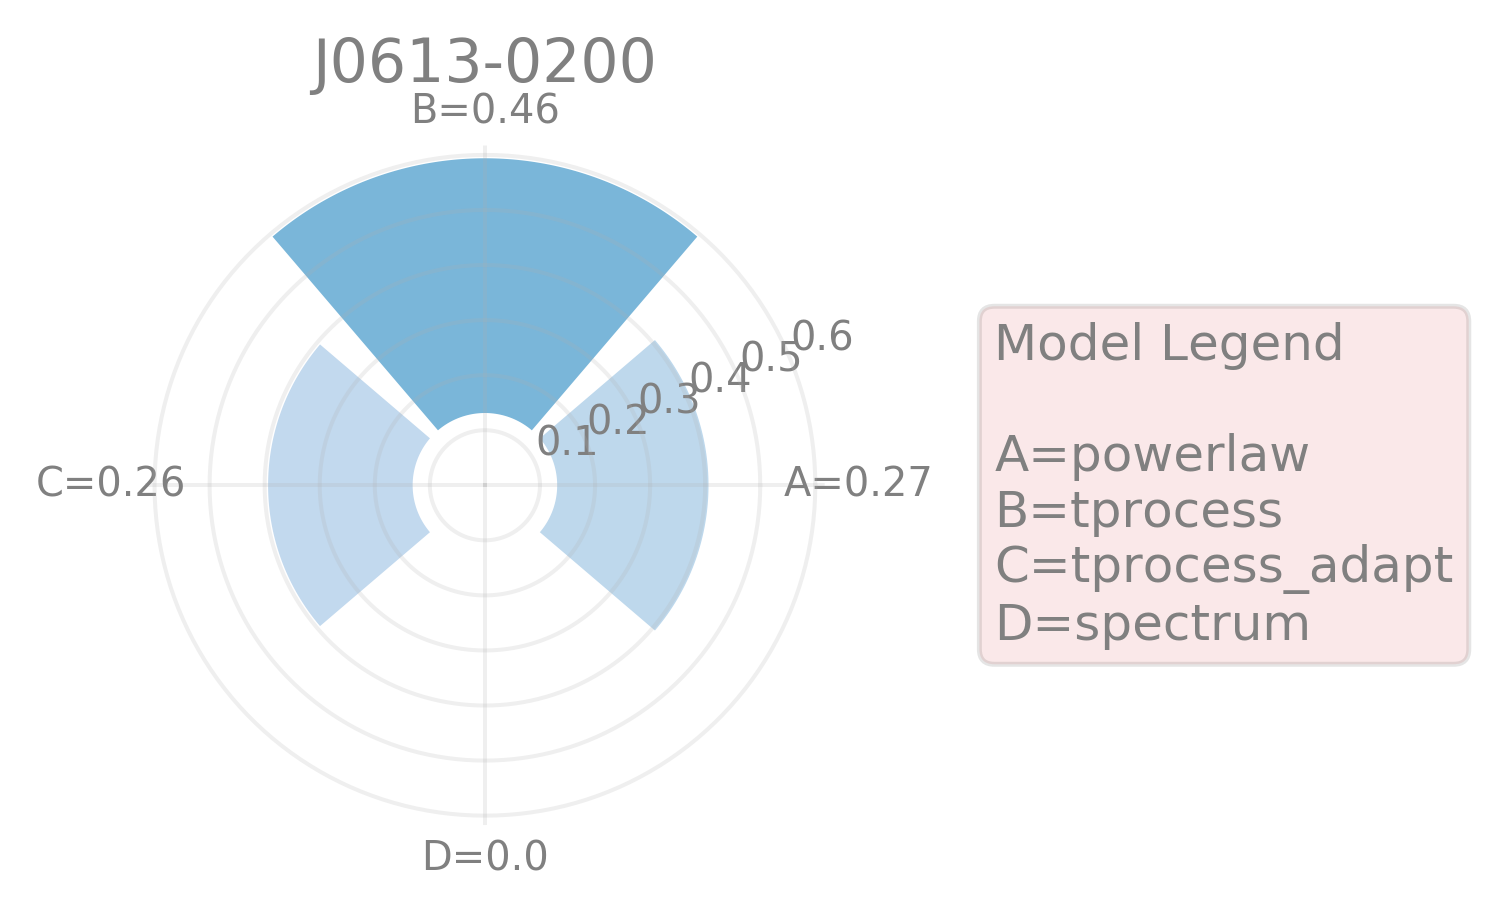

In [143]:
noise_flower(chain[burn:,-5], super_model, psr.name, model_dict)

# Testing models with GP DM variations

## [Aside] Grab all DMX data and store in json file

In [976]:
parfiles = sorted(glob.glob(datadir + '/*.par'))

In [977]:
from collections import OrderedDict

In [978]:
dmx_data = OrderedDict()
for par in parfiles:
    
    psrname = par.split('/')[-1].split('_')[0]
    
    with open(par, 'r') as f:
        data = f.read()
    
    dmx_data.update({psrname : OrderedDict()})
    for ii,line in enumerate(data.split('\n')):
        if 'DMX' in line:
            if len(line.split()) == 4:
                dmx_index = line.split()[0]
                
                dmx_epoch = float(data.split('\n')[ii+1].split()[1])
                dmx_val = float(line.split()[1].replace('D', 'e'))
                dmx_err = float(line.split()[3].replace('D', 'e'))
                dmx_r1 = float(data.split('\n')[ii+2].split()[1])
                dmx_r2 = float(data.split('\n')[ii+3].split()[1])
                dmx_f1 = float(data.split('\n')[ii+4].split()[1])
                dmx_f2 = float(data.split('\n')[ii+5].split()[1])
                
                dmx_data[psrname][dmx_index] = OrderedDict({'DMX_EPOCH' : dmx_epoch, 'DMX_VAL' : dmx_val,
                                               'DMX_ERR' : dmx_err, 'DMX_R1' : dmx_r1, 'DMX_R2' : dmx_r2,
                                               'DMX_F1' : dmx_f1, 'DMX_F2': dmx_f2})

In [979]:
with open('nanograv_11yr_dmx.json', 'w') as fp:
    json.dump(dmx_data, fp)

## [Aside] Making new parfiles stripped of DMX

In [193]:
parfiles = sorted(glob.glob(datadir + '/*.par'))

In [296]:
dmx_data = {}
for par in parfiles:
    
    psrname = par.split('/')[-1].split('_')[0]
    
    with open(par, 'r') as f:
        data = f.read()
    
    # filtering out DMX
    data_new = []
    for line in data.split('\n'):
        if 'DMX' not in line:
            data_new.append(line)
    
    # fitting DM
    for ii,line in enumerate(data_new):
        if 'DM' in line:
            dm_line = ii
            data_new[ii] = line + '  1'
    
    # adding and fitting DM1, DM2
    data_new.insert(dm_line+1, 'DM1            0                         1')
    data_new.insert(dm_line+2, 'DM2            0                         1')
    
    # print out new .par files
    with open('./partim_no_noise_dmgp/' + psrname + '_dmgp.par', 'w') as fnew:
        for line in data_new:
            print >>fnew, line
    with open('./partim_no_noise_nodmx/' + psrname + '_nodmx.par', 'w') as fnew:
        for line in data_new:
            print >>fnew, line

## Get par, tim, and noisefiles

In [3]:
psr = Pulsar('./partim_no_noise_dmgp/J2010-1323_dmgp.par',
             './partim_no_noise_dmgp/J2010-1323_NANOGrav_11yv0.tim',
              ephem='DE436')

In [7]:
noisefiles = sorted(glob.glob('../11yr_stochastic_analysis/nano11y_data/noisefiles/*.json'))

params = {}
for noisefil in noisefiles:
    with open(noisefil, 'r') as fp:
        params.update(json.load(fp))

## Setup GP model selection

In [145]:
red_psd = ['powerlaw', 'tprocess']
dm_psd = ['powerlaw', 'tprocess']
dm_annual = [True, False]
white_vary = False

In [146]:
# Create list of pta models for our model selection
nmodels = len(red_psd) * len(dm_psd) * len(dm_annual)
mod_index = np.arange(nmodels)

pta = dict.fromkeys(mod_index)
model_dict = []
ct = 0
for red in red_psd:
    for dm in dm_psd:
        for dm1yr in dm_annual:
            pta[ct] = models.model_singlepsr_noise(psr, psd=red, 
                                                   noisedict=params, 
                                                   white_vary=white_vary,
                                                   dm_var=True, 
                                                   dm_psd=dm, dm_annual=dm1yr)
            model_dict.append([red, dm, dm1yr])
            ct += 1

INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_efac to 1.17938
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_efac to 1.02818
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_efac to 1.02481
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_efac to 1.05483
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_log10_equad to -9.07445
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_equad to -6.00887
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_equad to -9.07558
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_equad to -9.62523
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_ecorr to -7.23339
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_ecorr to -6.10585
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_ecorr

INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_equad to -6.00887
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_equad to -9.07558
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_equad to -9.62523
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_ecorr to -7.23339
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_ecorr to -6.10585
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_ecorr to -8.06179
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_log10_ecorr to -6.88707


In [148]:
# Instanciate a collection of models
super_model = model_utils.HyperModel(pta)

In [149]:
super_model.params

["J2010-1323_dm_gp_gamma":Uniform(0,7),
 "J2010-1323_dm_gp_log10_A":Uniform(-20,-11),
 "J2010-1323_dm_s1yr_log10_Amp":Uniform(-10,-2),
 "J2010-1323_dm_s1yr_phase":Uniform(0,6.28318530718),
 "J2010-1323_gamma":Uniform(0,7),
 "J2010-1323_log10_A":Uniform(-20,-11),
 "J2010-1323_dm_gp_alphas": InvGamma(1.0,1.0)[30],
 "J2010-1323_alphas": InvGamma(1.0,1.0)[30]]

In [150]:
outdir = '../chains/rednoise_modelselection/{}/dm_gp/'.format(psr.name)
sampler = super_model.setup_sampler(resume=False, outdir=outdir)

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding DM annual prior draws...

Adding nmodel uniform distribution draws...



In [151]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [153]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [158]:
model_dict

[['powerlaw', 'powerlaw', True],
 ['powerlaw', 'powerlaw', False],
 ['powerlaw', 'tprocess', True],
 ['powerlaw', 'tprocess', False],
 ['tprocess', 'powerlaw', True],
 ['tprocess', 'powerlaw', False],
 ['tprocess', 'tprocess', True],
 ['tprocess', 'tprocess', False]]

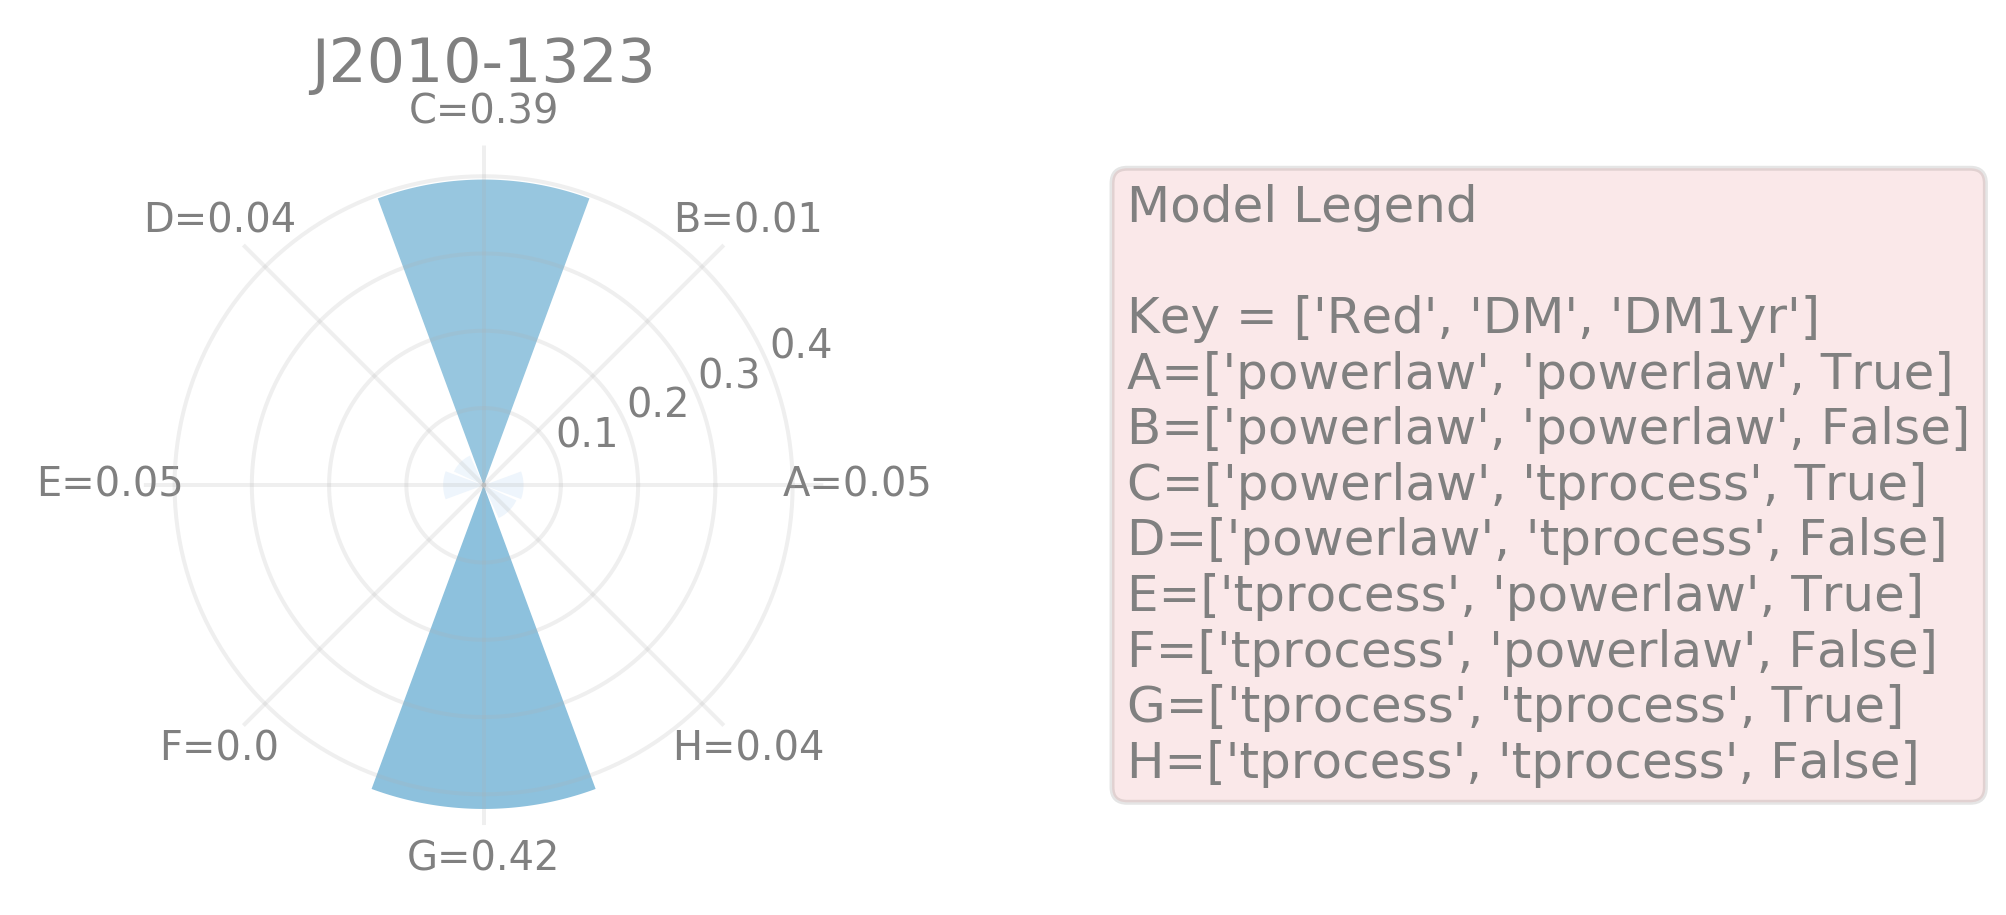

In [170]:
noise_flower(chain=chain[burn:, -5], super_model=super_model, psrname=psr.name, 
             model_dict=model_dict, key=['Red', 'DM', 'DM1yr'])

## Setup DM GP model selection between diagonal and non-diagonal kernels

The analysis above seems to indicate that `J2010-1323` wants an annual-DM term whenever a Fourier basis representation of the DM variations is used. We use that informatio in the following. We also fix the red-noise PSD to be a `power-law`.

In [8]:
# Create list of pta models for our model selection
nmodels = 4
mod_index = np.arange(nmodels)

pta = dict.fromkeys(mod_index)
model_dict = []

# red = powerlaw, dm = dmx-like, dm_annual=False
pta[0] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=False, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', dm_nondiag_kernel='dmx_like')
model_dict.append(['powerlaw', 'dmx_like', 'False'])

# red = powerlaw, dm = powerlaw, dm_annual=True
pta[1] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=False, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='diag', dm_psd='powerlaw', 
                                      dm_annual=True)
model_dict.append(['powerlaw', 'powerlaw', 'True'])

# red = powerlaw, dm = quasi-periodic, dm_annual=False
pta[2] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=False, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', dm_nondiag_kernel='periodic')
model_dict.append(['powerlaw', 'quasi_periodic', 'False'])

# red = powerlaw, dm = quasi-periodic_rfband, dm_annual=False
pta[3] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=False, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', dm_nondiag_kernel='periodic_rfband')
model_dict.append(['powerlaw', 'quasi_periodic_rfband', 'False'])

INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_efac to 1.17938
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_efac to 1.02818
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_efac to 1.02481
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_efac to 1.05483
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_log10_equad to -9.07445
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_equad to -6.00887
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_equad to -9.07558
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_equad to -9.62523
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_ecorr to -7.23339
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_ecorr to -6.10585
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_ecorr

In [9]:
# Instanciate a collection of models
super_model = model_utils.HyperModel(pta)

In [13]:
outdir = '../chains/rednoise_modelselection/{}/dmgp_diag_vs_nondiag/'.format(psr.name)
sampler = super_model.setup_sampler(resume=False, outdir=outdir)

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding DM annual prior draws...

Adding nmodel uniform distribution draws...



In [14]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50,)

In [16]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

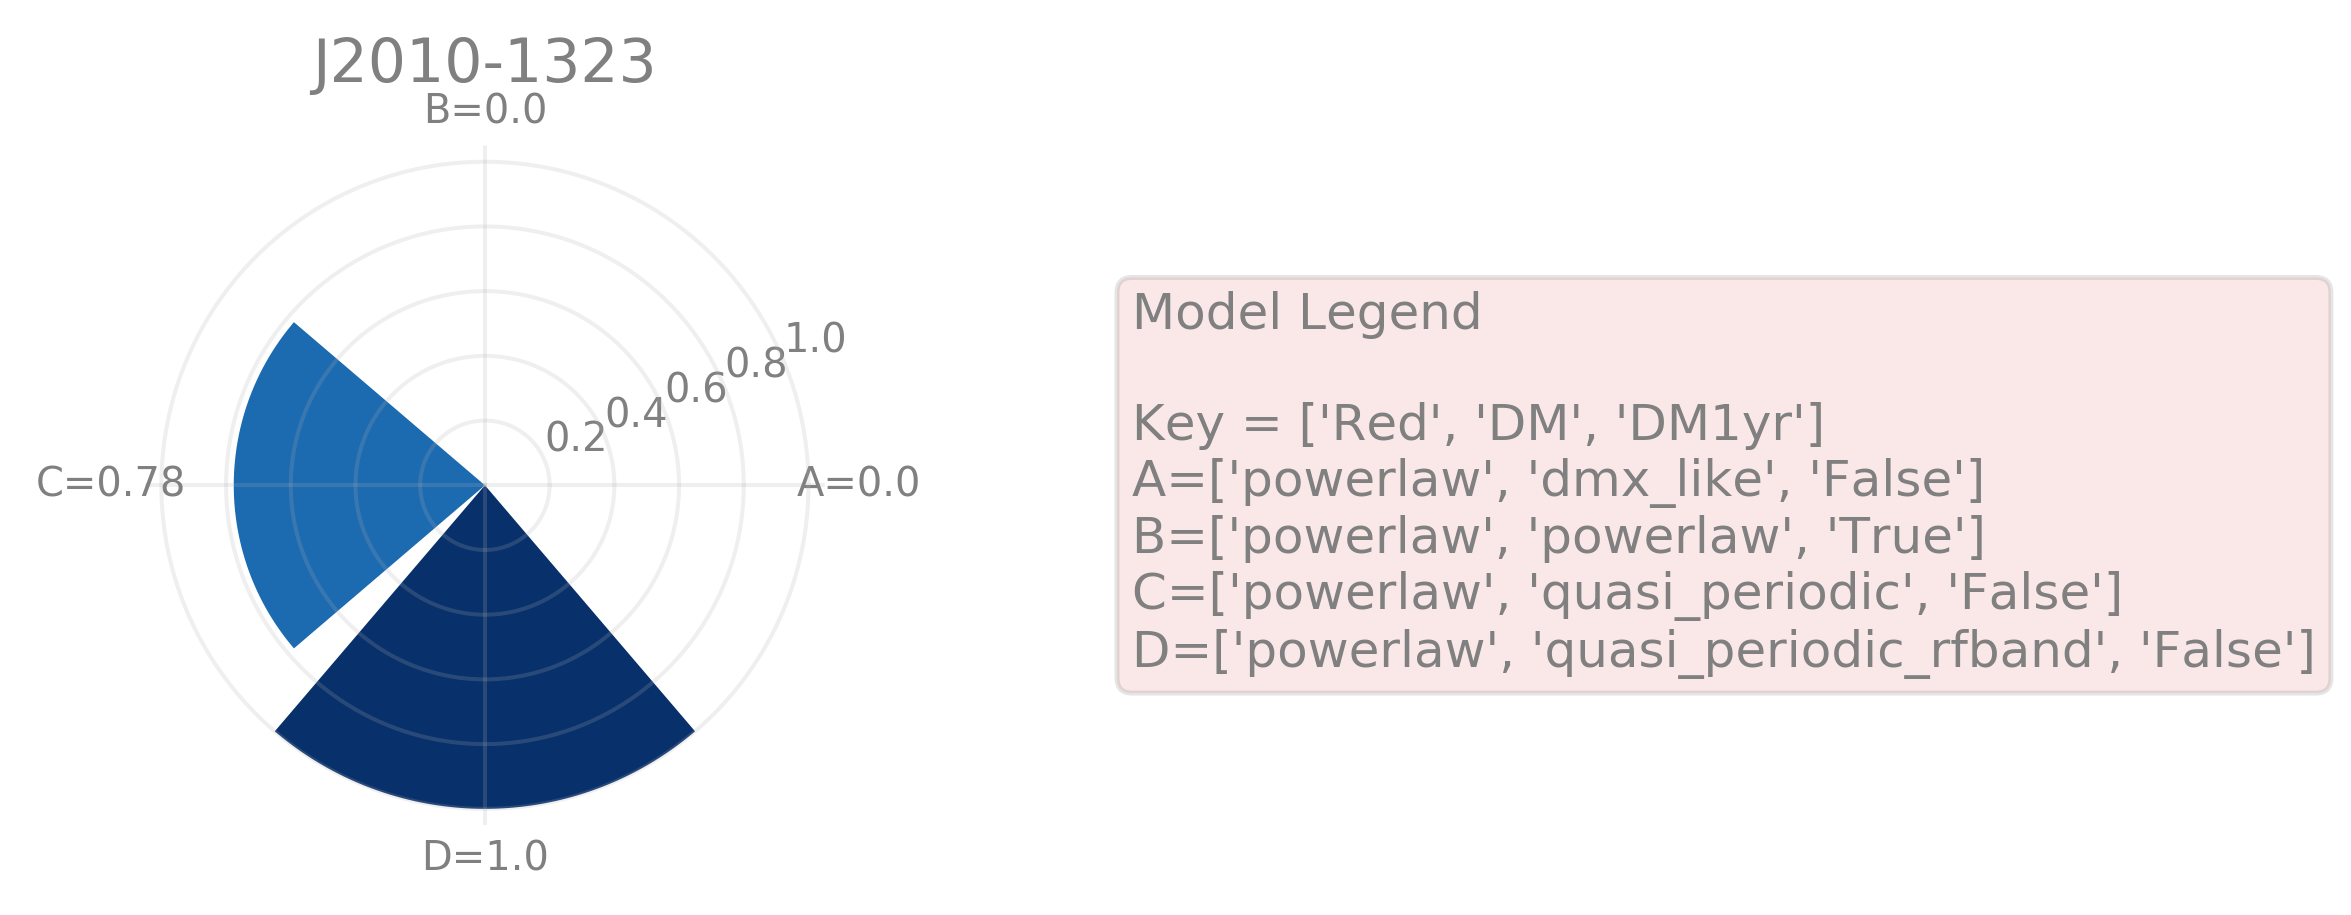

In [21]:
noise_flower(chain=chain[burn:, -5], super_model=super_model, psrname=psr.name, 
             model_dict=model_dict, key=['Red', 'DM', 'DM1yr'], norm2max=True)